This notebook refers [this blog post on BiT (BigTransfer)](https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html). 

## Setup and imports

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

## Flowers dataset 

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
)

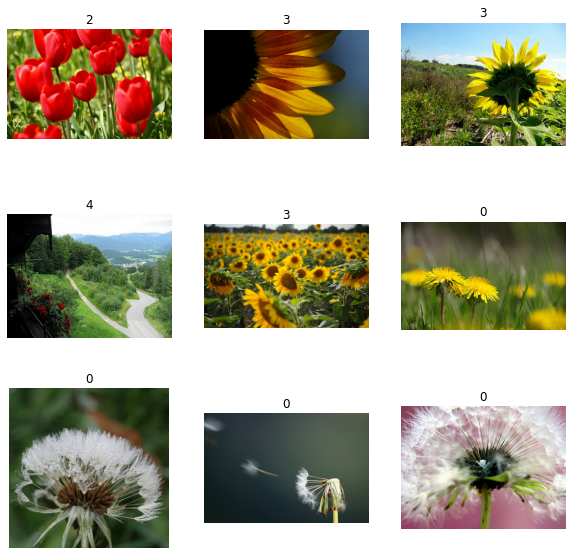

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## Training setup

In [ ]:
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]
BATCH_SIZE = 64
RESIZE_TO = 224
AUTO = tf.data.AUTOTUNE
SCHEDULE_LENGTH = (SCHEDULE_LENGTH * 512 / BATCH_SIZE) 

In [ ]:
# Preprocessing helper functions

# Create data pipelines for training and testing:

STEPS_PER_EPOCH = 10

DATASET_NUM_TRAIN_EXAMPLES = tf.data.experimental.cardinality(train_ds).numpy()
  
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [384, 384])
    image = tf.image.random_crop(image, [RESIZE_TO, RESIZE_TO, 3])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def preprocess_test(image, label):
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

pipeline_train = (train_ds
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  
                  .map(preprocess_train, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

pipeline_test = (validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))

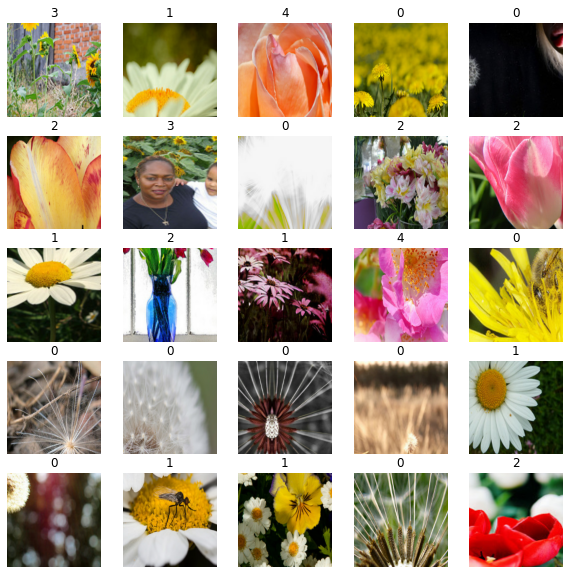

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

## Model building and other related utils

In [ ]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

In [ ]:
class ProductRecognizer(tf.keras.Model):
  def __init__(self, module):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(5, kernel_initializer="zeros")
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    dense1_representations = self.dense1(bit_embedding)
    return dense1_representations

In [ ]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=2, mode="auto",
    restore_best_weights=True
)

In [ ]:
def plot_training(H):
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Losses", fontsize=14)
    plt.legend(loc="lower left")
    plt.show()

## Model training and export

Epoch 1/400
10/10 [==============================] - 43s 2s/step - loss: 0.7986 - accuracy: 0.7312 - val_loss: 0.1756 - val_accuracy: 0.9618
Epoch 2/400
10/10 [==============================] - 20s 2s/step - loss: 0.1770 - accuracy: 0.9500 - val_loss: 0.1007 - val_accuracy: 0.9655
Epoch 3/400
10/10 [==============================] - 20s 2s/step - loss: 0.1112 - accuracy: 0.9609 - val_loss: 0.1022 - val_accuracy: 0.9618
Epoch 4/400
10/10 [==============================] - 20s 2s/step - loss: 0.1571 - accuracy: 0.9469 - val_loss: 0.0760 - val_accuracy: 0.9709
Epoch 5/400
10/10 [==============================] - 20s 2s/step - loss: 0.1251 - accuracy: 0.9578 - val_loss: 0.0791 - val_accuracy: 0.9673
Epoch 6/400
10/10 [==============================] - 20s 2s/step - loss: 0.0840 - accuracy: 0.9703 - val_loss: 0.0734 - val_accuracy: 0.9655
Epoch 7/400
10/10 [==============================] - 20s 2s/step - loss: 0.0971 - accuracy: 0.9750 - val_loss: 0.0638 - val_accuracy: 0.9673
Epoch 8/400
1

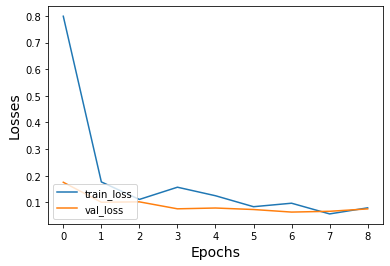

In [ ]:
model = ProductRecognizer(module=module)
model.compile(optimizer=optimizer,
              loss=loss_fn, metrics=["accuracy"])

history = model.fit(
    pipeline_train,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    validation_data=pipeline_test,
    callbacks=[es]                                     
)

plot_training(history)

In [ ]:
final_acc_train = history.history["accuracy"][-1]
model.save(f"flower_model_bit_{final_acc_train}")

INFO:tensorflow:Assets written to: flower_model_bit_0.96875/assets


INFO:tensorflow:Assets written to: flower_model_bit_0.96875/assets


In [ ]:
!tar cf flower_model_bit_{final_acc_train}.gz flower_model_bit_{final_acc_train}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/flower_model_bit_0.96875.gz /content/drive/MyDrive/